<a href="https://colab.research.google.com/github/john-vastola/RL-at-Harvard-tutorial-2022/blob/main/RL_tutorial_companion_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#<center>An introduction to reinforcement learning @ Harvard RL Workshop 2022</center>
## <center>A companion notebook by John Vastola and Lucy Lai</center>

<center><img src="https://github.com/john-vastola/RL-at-Harvard-tutorial-2022/blob/main/images/RL_pacman_schematic.png?raw=true" alt="drawing" width="600"/></center>

**Welcome to the reinforcement learning tutorial!** The goal of this tutorial is to present a brief introduction to

(i) the basic concepts of reinforcement learning (RL), and 

(ii) how those concepts might relate to the brain. 

This companion notebook contains demos which complement the main presentation, plus summaries of some of the essential points. It is self-contained, and only uses basic Python packages.

The structure of the notebook is as follows:

1.   The Rescorla-Wagner model of classical conditioning
2.   Generalizing Rescorla-Wagner using the temporal difference learning model
3.   Intermission: Mathematical formulation of reinforcement learning problems 
4.   Temporal difference learning as a general model-free prediction algorithm
5.   Q-learning and actor-critic: two general model-free control algorithms


For more details on everything discussed here, take a look at Sutton and Barto's classic RL textbook. Often considered the 'bible' of RL, it is a must-read if you are serious about learning the subject. 

Read it for free on Sutton's website here: http://incompleteideas.net/book/the-book-2nd.html

In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.animation as animation
from IPython.display import HTML

%matplotlib inline

In [2]:
!mkdir results
!mkdir results/RW
!mkdir results/TDcc
!mkdir results/tabular_control

---------------------------

## 1. The Rescorla-Wagner model of classical conditioning

The **Rescorla-Wagner model** attempts to capture basic features of classical conditioning experiments. In these experiments, something intrinsically rewarding (e.g. food) is paired with something not intrinsically rewarding (e.g. a bell sound). Famously, in the experiments of Pavlov, the initially unrewarding stimulus prompted a salivation response in dogs if it was a reliable predictor of food.

Some terminology:

*   *Unconditioned stimulus* (US): an intrinsically rewarding stimulus, like food
*   *Conditioned stimulus* (CS): stimulus without intrinsic reward, which needs to be paired with a US to prompt a similar response
*   *Unconditioned response* (UR): an 'in-born' response, e.g. salivating when food is nearby
*   *Conditioned response* (CR): prompted by stimuli which predict reward, e.g. salivating when hearing a food-associated bell

<center><img src="https://github.com/john-vastola/RL-at-Harvard-tutorial-2022/blob/main/images/bell_to_meat.png?raw=true" width="200"/></center>

The idea of the Rescorla-Wagner model is pretty simple. Each CS is associated with an **association strength** $w$, and the animal is assumed to compare the reward it receives with the sum of the association strengths of all CS that appeared in the trial. For each trial $t$, the animal receives a reward $R_t$ and uses its current association strength vector $\mathbf{w}_t$ to compute a **prediction error**
\begin{equation}
\delta_t := R_t - \mathbf{w}_t \cdot \mathbf{x}_t = R_t - \sum_{i \text{ with CS}_i \text{ present}} w_{t, i} \ .
\end{equation}
Here, a component $x_{t, j}$ of $\mathbf{x}_t$ is $1$ if CS$_j$ is present in that trial, and $0$ if it is not.

*  If the prediction error is zero, the animal doesn't need to update its model of the world, since the association strengths completely 'explain' the amount of reward it received.

*  If the prediction error is positive, the animal received *more* reward than expected, and the CS that appeared in that trial should be *more* associated with reward than before.

*  If the prediction error is negative, the animal received *less* reward than expected, and the CS that appeared in the trial should be *less* associated with reward.

The change in association strengths is assumed to be proportional to how 'surprising' a given trial was:
\begin{equation}
\mathbf{w}_{t+1} = \mathbf{w}_t + \alpha \ \delta_t \ \mathbf{x}_t 
\end{equation}
where $\alpha > 0$ is the learning rate, and where the $\mathbf{x}_t$ factor enforces the fact that the CS that don't appear in the trial don't get their association strengths updated.

Below is some code for visualizing the predictions of the Rescorla-Wagner model in the context of simple classical conditioning experiments.

In [21]:
# @title Plotting code

# Plots the results of an 'experiment' with the Rescorla-Wagner model.
def plot_experiment_cc_RW(num_trials, R, x, w, delta, name='exp', show_legend=True):
  trials_list = np.arange(1, num_trials + 1)
  num_CS = w.shape[1]
  
  num_linestyles= 4
  lines = ["-","--","-.",":"]

  fig, ax = plt.subplots(nrows=1, ncols=4, figsize=((27,4)))         # Set up multi-panel figure


  # Plot reward as a function of trial number
  ax[0].plot(trials_list, R, color='black', linewidth=4)
  ax[0].set_xlabel("Trial number", fontsize=20)
  ax[0].set_ylabel("Reward", fontsize=20)
  ax[0].set_title("Presence of reward associated with US", fontsize=20)
  ax[0].set_ylim(0,None)


  # Plot presence (x) and association strengths (w) as a function of trial number
  for j in range(num_CS):
    ax[1].plot(trials_list, x[:,j], label="CS"+str(j+1), linestyle=lines[j%num_linestyles], linewidth=4)
    ax[2].plot(trials_list, w[:,j], label="CS"+str(j+1), linestyle=lines[j%num_linestyles], linewidth=4)
  
  ax[1].set_xlabel("Trial number", fontsize=20)
  ax[1].set_ylabel("Presence", fontsize=20)
  ax[1].set_title("Presence of each CS", fontsize=20)
  ax[1].set_ylim(0, None)
  if show_legend:
    ax[1].legend(fontsize=18)

  ax[2].set_xlabel("Trial number", fontsize=20)
  ax[2].set_ylabel("Association strength", fontsize=20)
  ax[2].set_title("Associations of each CS with the US", fontsize=20)
  if show_legend:
    ax[2].legend(fontsize=18)


  # Plot prediction error as function of trial number
  ax[3].plot(trials_list[:-1], delta, color='red', linewidth=4)
  ax[3].set_xlabel("Trial number", fontsize=20)
  ax[3].set_ylabel("Prediction error", fontsize=20)
  ax[3].set_title("Prediction error over time", fontsize=20)

  plt.subplots_adjust(wspace=0.25)

  plt.savefig('results/RW/RW_'+name+'.png', bbox_inches='tight')
  plt.savefig('results/RW/RW_'+name+'.svg', bbox_inches='tight')
  plt.show()        # Show final plot

  return


In [22]:
# Performs a classical conditioning 'experiment' by applying the Rescorla-Wagner update rule for some number of trials.
def perform_experiment_cc_RW(num_trials, R, x, alpha):
  w, delta = np.zeros((num_trials, num_CS)), np.zeros(num_trials-1)           # initialize association strengths and prediction errors

  # For each trial, apply Rescorla-Wagner update to association strengths.
  for t in range(num_trials-1):
    delta[t] = R[t] - np.dot(w[t], x[t])      # Compute prediction error:    delta = (reward if present) - (sum of association strengths of CS that are present)
    w[t+1] = w[t] + alpha*delta[t]*x[t]       # Update association strengths:   dw = (learning rate)*(prediction error)*(presence)  ; only CS that are present get updated

  return w, delta

In [23]:
# Basic Rescorla-Wagner model parameters
R_US = 10       # reward associated with unconditioned stimulus; maximum 'association' US can support
num_CS = 2      # number of conditioned stimuli; these rely on an unconditioned stimulus to be associated with reward
alpha = 0.1     # learning rate (this needs to be somewhat smaller than 1 for the model output to be plausible)

### Experiment: both reward and CS always present

<center><img src="https://github.com/john-vastola/RL-at-Harvard-tutorial-2022/blob/main/images/bell_to_meat.png?raw=true" width="200"/></center>

The simplest experiment one can design is one where there is a single CS, and both the reward and CS are present in every trial. In this case, the association strength of the CS will approach its maximum and stay there.

Running experiment with learning rate alpha =  0.5 ...


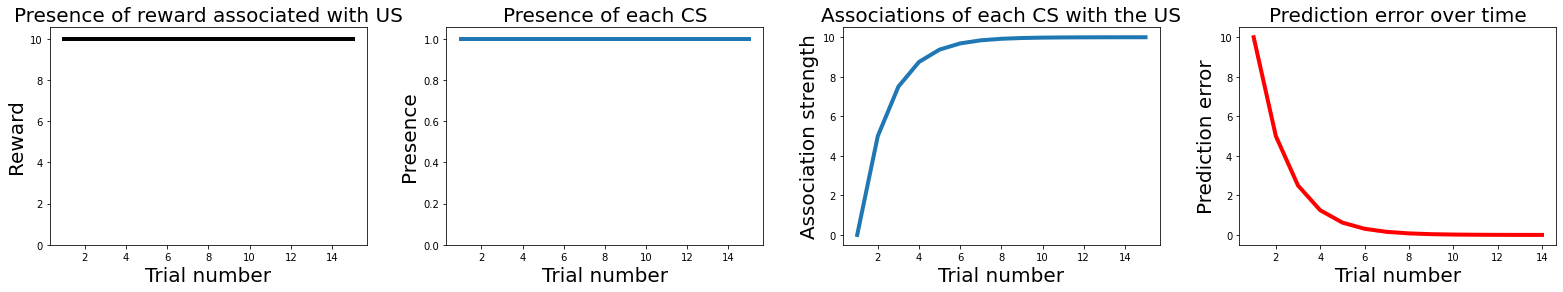

Running experiment with learning rate alpha =  2 ...


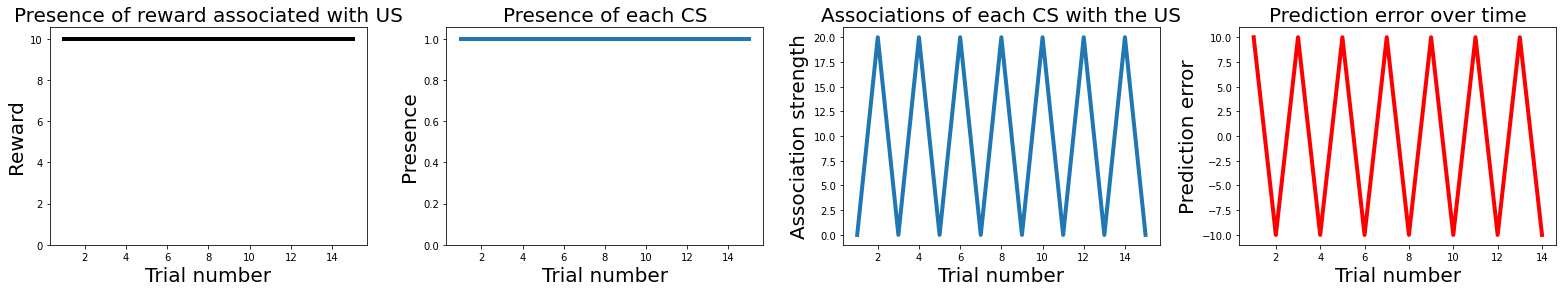

In [24]:
# Experimental design: classical conditioning, both reward and CS always present
num_CS = 1                                # number of conditioned stimuli
num_trials = 15                           # number of trials
R = R_US*np.ones(num_trials)              # presence or absence of US and associated reward;  R[t] = R_US  if present for trial t, and zero otherwise 
x = np.ones((num_trials, num_CS))         # presence or absence of CS;   x[t, j] = 1  if CS_j is present for trial t, and zero otherwise


# Perform the experiment and plot the results
alpha_small, alpha_large = 0.5, 2         # Two different learning rates: one 'small', and one 'large'

print("Running experiment with learning rate alpha = ",  alpha_small,"...")
w, delta = perform_experiment_cc_RW(num_trials, R, x, alpha_small)
plot_experiment_cc_RW(num_trials, R, x, w, delta, name='trivial_exp_smallalpha', show_legend=False)

print("Running experiment with learning rate alpha = ",  alpha_large,"...")
w, delta = perform_experiment_cc_RW(num_trials, R, x, alpha_large)
plot_experiment_cc_RW(num_trials, R, x, w, delta, name='trivial_exp_largealpha', show_legend=False)

### Experiment: blocking

<center><img src="https://github.com/john-vastola/RL-at-Harvard-tutorial-2022/blob/main/images/blocking_png.png?raw=true" width="600"/></center>

Historically, the RW was designed to recapitulate *blocking*, which is when learning the association between an US and a CS appears to prevent learning the association between the US and a different CS. In the RW model, once the association between US and the first CS is learned, the prediction error is zero, so there is no need to learn an association between the US and the second CS.

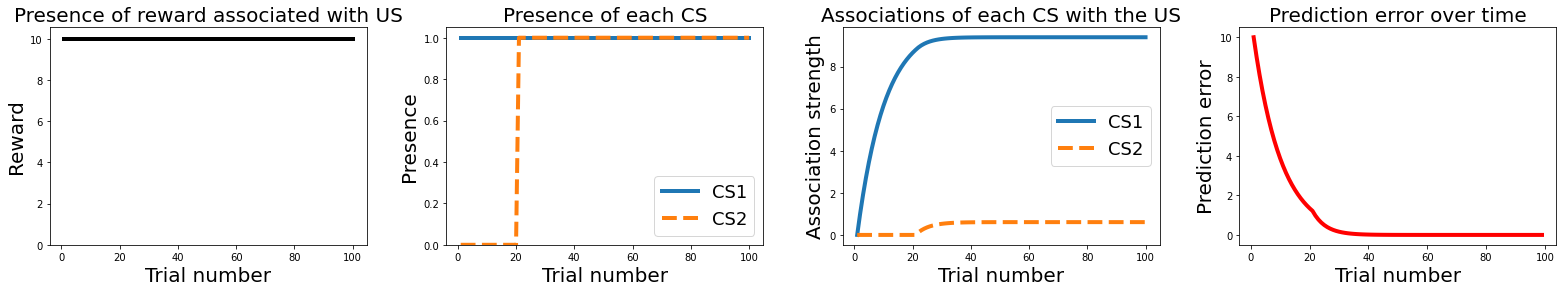

In [25]:
# Experimental design: blocking, initially CS1 present and CS2 absent
num_CS  = 2                               # number of conditioned stimuli
num_trials = 100                          # number of trials
R = R_US*np.ones(num_trials)              # presence or absence of US and associated reward
x = np.ones((num_trials, num_CS))         # presence or absence of CS
x[:20,1] = 0                              # the second stimulus is not initially present


# Perform the experiment and plot the results
w, delta = perform_experiment_cc_RW(num_trials, R, x, alpha)
plot_experiment_cc_RW(num_trials, R, x, w, delta, name='blocking_exp')

### Experiment: more complicated example

<center><img src="https://github.com/john-vastola/RL-at-Harvard-tutorial-2022/blob/main/images/negative_association.png?raw=true" width="800"/></center>

Here is a more complicated example involving negative association strengths. There are two conditioned stimuli, and the second only appears when reward is not present.

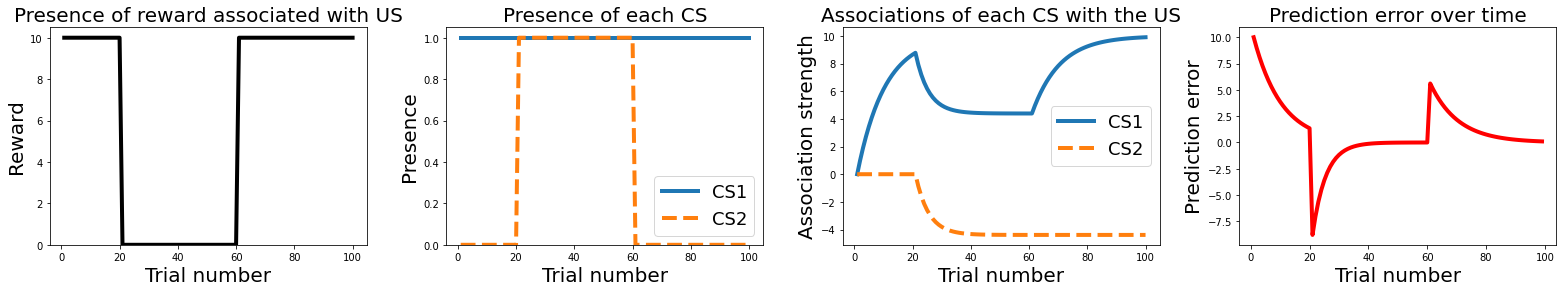

In [26]:
# Experimental design: more complicated example
num_CS = 2                                # number of conditioned stimuli
num_trials = 100                          # number of trials
R = R_US*np.ones(num_trials)              # presence or absence of US and associated reward 
x = np.ones((num_trials, num_CS))         # presence or absence of CS

x[:20,1] = 0                              # the second stimulus is not initially present
R[20:60] = 0                              # when the second stimulus appears, there is no reward
x[60:,1] = 0                              # when the second stimulus disappears, the reward returns


# Perform the experiment and plot the results
w, delta = perform_experiment_cc_RW(num_trials, R, x, alpha)
plot_experiment_cc_RW(num_trials, R, x, w, delta, name='complex_exp')

--------------------------------------

## 2. Generalizing Rescorla-Wagner using the temporal difference learning model

Despite its successes and appealing simplicity, there are (at least) two notorious problems with the Rescorla-Wagner model. The first is conceptual: from an animal's point of view, experience is continuous rather than trial-based. Is it possible to model how associations between stimuli are changing *within* a trial? 

The second problem is that the model fails to explain **higher-order conditioning**, a phenomenon observed in many classical conditioning experiments. 

<center><img src="https://github.com/john-vastola/RL-at-Harvard-tutorial-2022/blob/main/images/higher_order_conditioning.png?raw=true" width="500"/></center>

For example, pairing a bell sound with food, and then pairing a light flash with the bell sound, can in some circumstances create a limited association between the light flash and the food reward (i.e. salivation is observed). The association can be created and maintained even if the food reward and light flash *never* co-occur. This is an example of *second-order conditioning*, but higher-order conditioning has also been observed.

The **temporal difference (TD) model** of classical conditioning experiments, originally proposed by Sutton and Barto, attempts to tackle both problems. Addressing the first problem is somewhat trivial, since one can just say that $t$ now represents moments in time rather than trials. 

(There is some subtlety about how to generalize the $\mathbf{x}_t$ in this case, though; we will stick with the so-called *presence representation*, and say that $x_{t, j} = 1$ if CS$_j$ is present at time $t$, and $x_{t, j} = 0$ is CS$_j$ is absent at time $t$. Obviously this isn't totally realistic, but it is simple and does not change the most important qualitative predictions of the model.)



The way it addresses the second problem is much more interesting, and has important ramifications for how we think about the goal of the brain during such experiments. Sutton and Barto essentially propose that the animal is not trying to predict how much reward it is *about to get*, but how much reward it *will* get after a long time. That is, the brain is trying to predict the **(discounted) future reward**
\begin{equation}
G_t := R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + \cdots
\end{equation}
where the discount factor $\gamma$ is between $0$ and $1$. Temporal discounting means the animal tends to focus on getting rewards in the near future, since rewards in the far future are viewed as less valuable. In slogan form: all else being equal, you want the cookie *now* instead of *later*.



In the Rescorla-Wagner model, the sum of association strengths (of the CS that are present) was attempting to predict the next trial's reward. In the TD model, it is attempting to predict the (discounted) future reward, which includes the rewards of not just the next trial, but all future trials.

The quantity
\begin{equation}
V(\mathbf{x}_t) := \mathbf{w}_t \cdot \mathbf{x}_t
\end{equation}
is special; we will call it the **value** of the state $\mathbf{x}_t$. The function $V$ will be referred to as the **value function**.

As in the Rescorla-Wagner model, the animal will compute a prediction error, which this time depends on the (discounted) future reward $G_t$. There is one problem: *we can't precisely know how much reward we will get in the future until the future has already happened!* 

How can we deal with this? Note that
\begin{equation}
G_t = R_{t+1} + \gamma \ G_{t+1} \ .
\end{equation}
If $V(\mathbf{x}_t)$ is a good guess for $G_t$, then $V(\mathbf{x}_{t+1})$ should be a good guess for $G_{t+1}$. Hence, we can write that
\begin{equation}
G_t \approx R_{t+1} + \gamma \ V(\mathbf{x}_{t+1}) \ .
\end{equation}
The key innovation of the TD model is that it assumes an animal, which does not have access to $G_t$, uses the above informed guess. This is a kind of **bootstrapping**: using an estimate to update another estimate. We don't *actually* know that $G_{t+1} = V(\mathbf{x}_{t+1})$, but will nonetheless use $V(\mathbf{x}_{t+1})$ to update $V(\mathbf{x}_{t})$ and hope for the best.

Given the above considerations, the TD model proposes using prediction error
\begin{equation}
\delta_t := R_{t+1} + \gamma V(\mathbf{x}_{t+1}) - V(\mathbf{x}_t)
\end{equation}
to update the association strengths $\mathbf{w}_t$. The actual updates are, as before,
\begin{equation}
\mathbf{w}_{t+1} = \mathbf{w}_t + \alpha \ \delta_t \ \mathbf{x}_t \Delta t \ .
\end{equation}
When $\gamma = 0$, one exactly recovers the Rescorla-Wagner model (up to the interpretation of the $t$ index).

Below is some code for visualizing the predictions of the TD model in the context of simple classical conditioning experiments.

In [15]:
# @title Plotting code

# Plots the results of an 'experiment'.
def plot_experiment_cc_TD(num_trials, R, x, w, delta, name='exp', show_legend=True):
  trials_list = np.arange(1, num_trials + 1)
  num_CS = w.shape[1]
  
  num_linestyles= 4
  lines = ["-","--","-.",":"]


  fig, ax = plt.subplots(nrows=1, ncols=4, figsize=((27,4)))         # Set up multi-panel figure


  # Plot reward as a function of trial number
  ax[0].plot(trials_list, R, color='black', linewidth=4)
  ax[0].set_xlabel("Time (s)", fontsize=20)
  ax[0].set_ylabel("Reward", fontsize=20)
  ax[0].set_title("Presence of reward associated with US", fontsize=20)
  ax[0].set_ylim(0,None)


  # Plot presence (x) and association strengths (w) as a function of trial number
  for j in range(num_CS):
    ax[1].plot(trials_list, x[:,j], label="CS"+str(j+1), linestyle=lines[j%num_linestyles], linewidth=4)
    ax[2].plot(trials_list, w[:,j], label="CS"+str(j+1), linestyle=lines[j%num_linestyles], linewidth=4)
  
  ax[1].set_xlabel("Time (s)", fontsize=20)
  ax[1].set_ylabel("Presence", fontsize=20)
  ax[1].set_title("Presence of each CS", fontsize=20)
  ax[1].set_ylim(0, None)
  if show_legend:
    ax[1].legend(fontsize=18)

  ax[2].set_xlabel("Time (s)", fontsize=20)
  ax[2].set_ylabel("Association strength", fontsize=20)
  ax[2].set_title("Associations of each CS with the US", fontsize=20)
  if show_legend:
    ax[2].legend(fontsize=18)


  # Plot prediction error as function of trial number
  ax[3].plot(trials_list[:-1], delta, color='red', linewidth=4)
  ax[3].set_xlabel("Time (s)", fontsize=20)
  ax[3].set_ylabel("Prediction error", fontsize=20)
  ax[3].set_title("Prediction error over time", fontsize=20)

  plt.subplots_adjust(wspace=0.25)
  plt.savefig('results/TDcc/TDcc_'+name+'.png', bbox_inches='tight')
  plt.savefig('results/TDcc/TDcc_'+name+'.svg', bbox_inches='tight')
  plt.show()        # Show final plot

  return

In [10]:
# Performs an 'experiment' by applying the TD update rule for some number of time steps.
def perform_experiment_cc_TD(num_trials, R, x, params):
  alpha, gamma, dt = params['alpha'], params['gamma'], params['dt']          # Get relevant model parameters

  w, delta = np.zeros((num_trials, num_CS)), np.zeros(num_trials-1)          # initialize association strengths and prediction errors

  # For each time step, apply TD update to association strengths.
  for t in range(num_trials-1):
    V_est, V_est_pred = np.dot(w[t], x[t]), np.dot(w[t], x[t+1])    # Current and predicted value estimates:   V_hat = w*x
    delta[t] = R[t+1] + gamma*V_est_pred - V_est                    # Compute prediction error:                delta = (predicted discounted sum of future rewards) - (current value estimate) 

    w[t+1] = w[t] + alpha*delta[t]*x[t]*dt                          # Update association strengths:               dw = (learning rate)*(prediction error)*(presence)*dt

  return w, delta

In [11]:
# Parameters for basic TD model of classical conditioning 
R_US = 10       # reward associated with unconditioned stimulus; maximum 'association' US can support
num_CS = 2      # number of conditioned stimuli; these rely on an unconditioned stimulus to be associated with reward
alpha = 0.1     # learning rate (this needs to be somewhat smaller than 1 for the model output to be plausible)
gamma = 0.1     # discount factor (between 0 and 1; smaller means future reward is considered less valuable than current reward)
dt = 1          # size of time step (in seconds)

params = {"alpha":alpha, "gamma":gamma, "dt":dt}

### Experiment: both reward and CS always present

<center><img src="https://github.com/john-vastola/RL-at-Harvard-tutorial-2022/blob/main/images/bell_to_meat.png?raw=true" width="200"/></center>

We can retry the simplest experiment, with a reward and a single CS always co-occuring, and see what changes when we modify the new parameter $\gamma$. While bootstrapping can be useful, we can see that it also might make learning slower.

Running experiment with discount factor of gamma =  0.1 ...


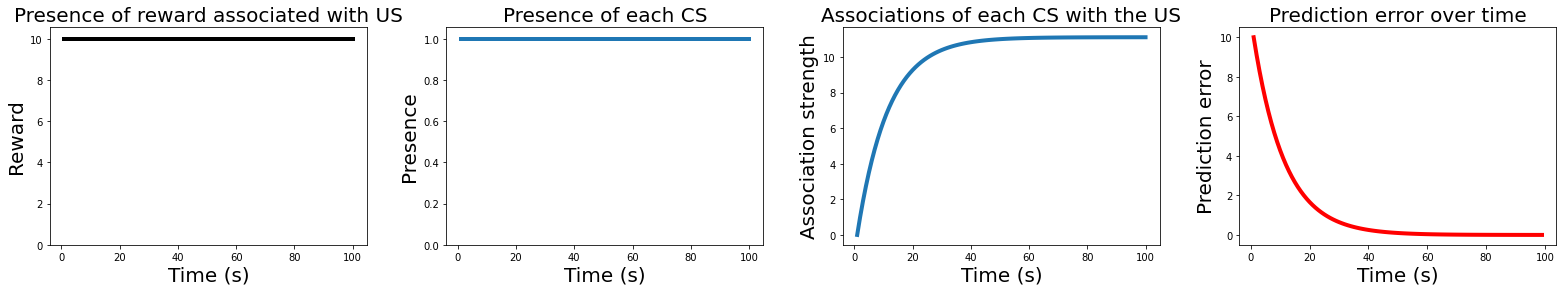


Running experiment with discount factor of gamma =  0.9 ...


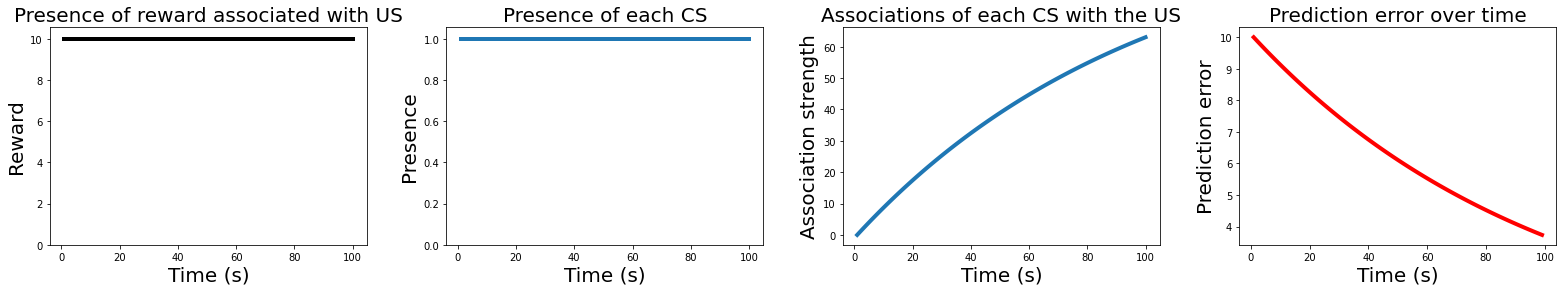

In [28]:
# Experimental design: classical conditioning, both reward and CS always present
num_CS = 1                                # number of conditioned stimuli
num_trials = 100                          # number of trials
R = R_US*np.ones(num_trials)              # presence or absence of US and associated reward;  R[t] = R_US  if present for trial t, and zero otherwise 
x = np.ones((num_trials, num_CS))         # presence or absence of CS;   x[t, j] = 1  if CS_j is present for trial t, and zero otherwise


# Perform the experiment and plot the results
params["gamma"] = 0.1
print("Running experiment with discount factor of gamma = ", params["gamma"] ,"...")
w, delta = perform_experiment_cc_TD(num_trials, R, x, params)
plot_experiment_cc_TD(num_trials, R, x, w, delta, name='basic_exp_small_gamma', show_legend=False)
print()


params["gamma"] = 0.9
print("Running experiment with discount factor of gamma = ", params["gamma"], "...")
w, delta = perform_experiment_cc_TD(num_trials, R, x, params)
plot_experiment_cc_TD(num_trials, R, x, w, delta, name='basic_exp_large_gamma', show_legend=False)

### Experiment: second-order conditioning

<center><img src="https://github.com/john-vastola/RL-at-Harvard-tutorial-2022/blob/main/images/second_order_cc_exp.png?raw=true" width="1000"/></center>

We can test out the claim that the TD model can capture second-order conditioning. Consider an experiment in which a bell sound predicts a food reward for two trials, and then a light flash predicts the same bell sound for two trials. How does changing the value of $\gamma$ (and hence the amount of bootstrapping) change the extent to which the light flash becomes associated with the food reward?

Running experiment with discount factor of gamma =  0.0 ...


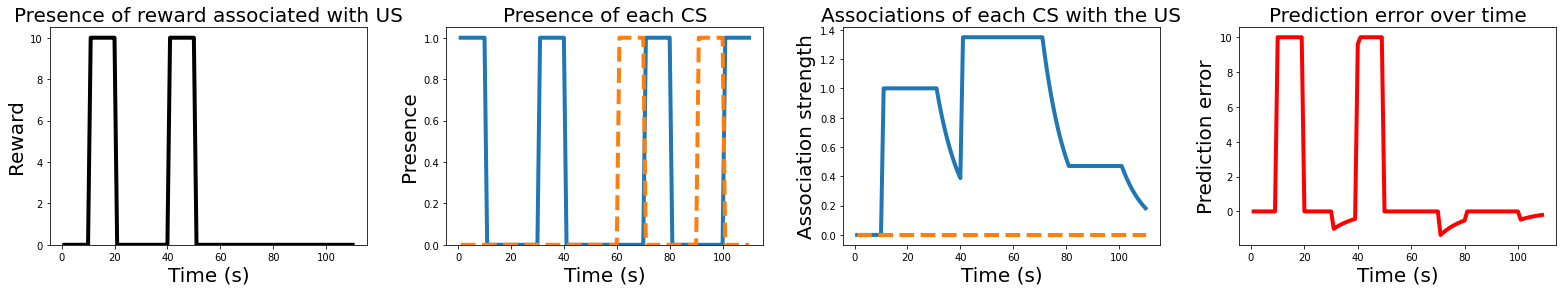


Running experiment with discount factor of gamma =  1 ...


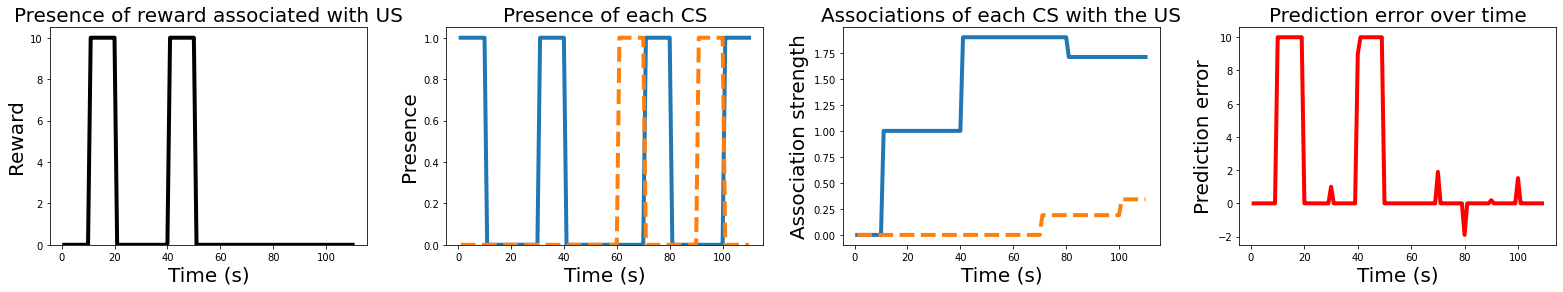

In [16]:
# Experimental design: classical conditioning, both reward and CS always present
num_trials = 110                          # number of trials
R = R_US*np.ones(num_trials)              # presence or absence of US and associated reward
x = np.ones((num_trials, num_CS))         # presence or absence of CS


# Trial 1: CS1 -> US
x[:10,0], x[:10,1], R[:10] = 1, 0, 0                 # initially, only CS1 present
x[10:20], R[10:20] = 0, R_US                         # no CS; reward present
x[20:30], R[20:30] = 0, 0                            # inter-trial interval

# Trial 2: CS1 -> US
x[30:40,0], x[30:40,1], R[30:40] = 1, 0, 0           # only CS1 present again
x[40:50], R[50:50] = 0, R_US                         # only reward present again
x[50:60], R[50:60] = 0, 0                            # inter-trial interval
 
# Trial 3: CS2 -> CS1
x[60:70,0], x[60:70,1], R[60:70] = 0, 1, 0           # only CS2 present
x[70:80,0], x[70:80, 1], R[70:80] = 1, 0, 0          # only CS1 present
x[80:90], R[80:90] = 0, 0                            # inter-trial interval

# Trial 4: CS2 -> CS1                     
x[90:100,0], x[90:100,1], R[90:100] = 0, 1, 0        # only CS2 present
x[100:110,0], x[100:110, 1], R[100:110] = 1, 0, 0    # only CS1 present


# Perform the experiment and plot the results
params["gamma"] = 0.0
print("Running experiment with discount factor of gamma = ", params["gamma"] ,"...")
w, delta = perform_experiment_cc_TD(num_trials, R, x, params)
plot_experiment_cc_TD(num_trials, R, x, w, delta, name='order2_small_gamma', show_legend=False)
print()

params["gamma"] = 1
print("Running experiment with discount factor of gamma = ", params["gamma"], "...")
w, delta = perform_experiment_cc_TD(num_trials, R, x, params)
plot_experiment_cc_TD(num_trials, R, x, w, delta, name='order2_large_gamma', show_legend = False)

---------------------

## 3. Intermission: Mathematical formulation of reinforcement learning problems

Before we describe the more general TD learning algorithm, as well as other useful reinforcement learning algorithms, we should have a more specific idea of the type of problem these algorithms are trying to solve. In this section (which contains no code), we briefly describe the mathematical formulation of reinforcement learning problems.

### General formulation of reinforcement learning problems

From here on out, we move away from psychology, and describe reinforcement learning in a more abstract setting. In general, there is an **agent** that exists in an **environment**. At any given time, the environment is in a particular **state**, which determines both (i) what the agent does next, and (ii) how the environment changes next. Depending on what the agent does and the state of the environment, the agent receives a **reward**, and the environment might change.

By 'reward', we include both positive and negative things the agent cares about, so costs are included as negative rewards. The goal of the agent is to maximize total (possibly discounted) reward (or to achieve some morally similar goal, like maximizing reward *rate*). 

More precisely, suppose that the environment is in a state $S_t$ at time $t$. The agent takes an action $A_t$, which yields a reward $R_{t+1}$, and the state of the environment changes to a state $S_{t+1}$. (The agent's action may or may not have contributed to this state change.) This process continues, either until some end condition is met (e.g. a player has won or lost a game), or indefinitely (e.g. a person acting in the world).

The agent acting in the changing environment produces a sequence
\begin{equation}
\cdots \to (S_t, R_t) \to A_t \to (S_{t+1}, R_{t+1}) \to A_{t+1} \to \cdots \ . 
\end{equation}

This process is popularly depicted by a diagram like

<center>
<figure>
<img src="https://github.com/john-vastola/RL-at-Harvard-tutorial-2022/blob/main/images/sb_loop.png?raw=true"  width="800"/>
<figcaption>From Sutton and Barto, Ch. 3.</figcaption>
</figure>
</center>


We assume that the agent has a policy $\pi$ that determines which actions it will take. $\pi(A_t | S_t)$ denotes the probability that the agent will take action $A_t$ given that the environment is in a state $S_t$. 

We also assume that the environment has some transition function $p(S_{t+1}, R_{t+1} | S_t, A_t)$, which determines the probability that it will transition to a state $S_{t+1}$ and give the agent a reward $R_{t+1}$, given that it was previously in the state $S_t$, and that the agent just took an action $A_t$.

Mathematically, this corresponds to a **Markov decision process**. The key assumption is that both what the agent does (i.e. its policy $\pi$) and how the environment changes (determined by its transition function $p$) only depend on the **most recent state of the environment**, and not on previous ones. 

While this assumption seems pretty strong, it is less problematic than it sounds, since what exactly is considered a 'state' is up to whoever defines the problem. If this formalism (and most of work in RL) is to apply, the notion of 'state' for a given problem should include whatever information is roughly necessary to determine what happens next. While this could include the entire previous history of the environment, in practice the *recent* history of the environment, plus some information related to the internal or latent states of the agent, is sufficient.

### Value functions for assessing the 'goodness' of a policy

As in the previous section, we define the **return** $G_t$ as the discounted future reward
\begin{equation}
G_t := R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + \cdots = \sum_{k = t + 1}^T \gamma^{k - t - 1} R_{k} \ .
\end{equation}
In general, the environment may behave somewhat randomly, so maximizing $G_t$ is not always possible, even with 'optimal' behavior. (Even the best poker player can have exceptionally bad luck.) The best an agent can hope for is to behave so that, *on average*, the return $G_t$ is maximized. 

To this end, we define the **value function** (or **state-value function**)
\begin{equation}
v_{\pi}(s) := \mathbb{E}_{\pi}\left[ G_t | S_t = s  \right]
\end{equation}
which quantifies the 'goodness' of being in a state $s$, given that the agent follows a policy $\pi$. We can similarly define the **Q-value function** (or **action-value function**)
\begin{equation}
q_{\pi}(s, a) := \mathbb{E}_{\pi}\left[ G_t | S_t = s, A_t = a  \right]
\end{equation}
which quantifies the 'goodness' of being in a state $s$ and taking an action $a$, given that the agent follows a policy $\pi$. 

It is useful to restate the goal of the agent (maximizing expected return) in terms of these functions. The goal is to find a policy $\pi_*$ which is *optimal*, in the sense that
\begin{equation}
v_{\pi_*}(s) \geq v_{\pi}(s) \ \text{ for all states } s \ ,
\end{equation}
where $\pi$ is any other policy. In words: no matter what state the agent begins in, following $\pi_*$ will yield a greater (or at least as great) return than following any other policy. Such a policy always exists for Markov decision processes, although it is generally not unique.

### The prediction and control problems

In general, there are two things we do not know: (i) the expected return of our current policy, and (ii) what the best policy is. 

Determining the expected return of our current policy $\pi$, i.e. evaluating $v_{\pi}(s)$ for all states $s$, is known as the **prediction problem**.

Determining the optimal policy $\pi_*$ is known as the **control problem**.

Solving the prediction problem by itself is clearly not enough to determine good policies. But since evaluating policies helps have a better idea of how to improve them, it is usually a key component of any good reinforcement learning method for solving the control problem.

In particular, many reinforcement learning approaches follow the spirit of **generalized policy iteration**: improve the evaluation of your current policy a little, then improve the policy a little, then improve the evaluation of the new policy a little, then improve the policy a little more, and so on.

In what follows, we will first showcase a solution to the prediction problem using temporal difference learning, and then show how this can be utilized to solve the control problem. 

-------------------

## 4. Temporal difference learning as a general model-free prediction algorithm

So far, we have been very focused on modeling classical conditioning experiments, in which an animal attempts to predict the appearance of some intrinsically valuable stimulus like food. But the temporal difference (TD) learning algorithm allows us to solve much more general prediction problems.

### Motivation for the TD algorithm

A useful fact is that the value function satisfies the **Bellman equation**, which reads
\begin{equation}
v_{\pi}(s) = \sum_{s', r, a} p(s', r | s, a) \pi(a | s) \left[ \ r + \gamma v_{\pi}(s') \ \right] \ .
\end{equation}
This equation is the basis for dynamic programming methods for solving reinforcement learning problems; such methods, while extremely interesting, only apply when the agent knows a perfect model of how the environment changes with time.

More usefully for our purposes, this equation is *also* the basis for the **temporal difference learning** algorithm for solving the prediction problem.

Suppose the agent would like to evaluate a policy $\pi$, and only obtains state and reward information from the environment (i.e. the agent has no model, accurate or not, of the environment's dynamics). 

Suppose, moreover, that the agent was recently in a state $s$, took an action $a$, received a reward $r$, and transitioned to a state $s'$. The Bellman equation says that
\begin{equation}
v_{\pi}(s) \approx r + \gamma v_{\pi}(s')
\end{equation}
on average, for the true value function $v_{\pi}(s)$. 

The idea behind the TD learning algorithm is to iteratively update $V_{\pi}(s)$, an estimate of the true value function, by comparing the left- and right-hand sides of that approximate equality. The difference between the two is extremely special, and is called the **prediction error**:
\begin{equation}
\delta := r + \gamma V_{\pi}(s') - V_{\pi}(s) \ .
\end{equation}
The name comes from the fact that $r + \gamma V_{\pi}(s')$ is an estimate of $G_t$, the return. Effectively, $\delta$ measures the difference between the apparent value of $G_t$, and the current best estimate ($V_{\pi}(s)$). 


### The TD algorithm

<center>
<figure>
<img src="https://github.com/john-vastola/RL-at-Harvard-tutorial-2022/blob/main/images/TDalgo.png?raw=true"  width="800"/>
</figure>
</center>


### A gridworld environment for testing reinforcement learning algorithms

How well does the TD algorithm actually work? To test this, we will try it out in a custom gridworld environment. 

**Gridworld problems**—where an agent moving around on a grid has to navigate to a goal as efficiently as possible—are a classic test case for reinforcement learning algorithms. Because it is easy to get intuition for how an agent *should* behave, it is clear whether policies are being evaluated properly, and whether an agent's current policy is good or bad.

In [ ]:
# @title Defining the gridworld environment
def grid_step(state, action, num_steps, env_params):
  terminal_state, step_limit = env_params["terminal_state"], env_params["step_limit"]
  grid_size = env_params["grid_size"]

  x = state%grid_size
  y = state//grid_size

  #print(x, y)

  if action == "up":
    y = (y - 1)*(y > 0)
  elif action == "down":
    y = (y + 1)*(y < (grid_size - 1)) + y*(y == grid_size - 1)
  elif action == "right":
    x = (x + 1)*(x < (grid_size - 1)) + x*(x == grid_size - 1)
  elif action == "left":
    x = (x - 1)*(x > 0)

  state = grid_size*y + x

  if state == terminal_state:
    done = True
    reward = 10 - 1
  else:
    reward = -1
    if num_steps >= step_limit:
      #print("hit step limit")
      done = True
    else:
      done = False
  
  return state, reward, done

In [ ]:
# @title Plotting and visualization code

def get_checkerboard(ax, grid_size, terminal_state):

  # Create checkerboard
  checkerboard = np.zeros((grid_size, grid_size))
  for i in range(grid_size):
    z = i%2
    checkerboard[i][z::2] = 1

  # Create colormap
  colors = ["antiquewhite", "seashell"] 
  cmap = LinearSegmentedColormap.from_list("checkerboard", colors, N=2)




  # Add goal square
  terminal_x = terminal_state%grid_size
  terminal_y = terminal_state//grid_size
  rect_goal = plt.Rectangle((-0.5 +terminal_x,-0.5 + terminal_y), 1, 1, fc="palegreen", ec=None, fill=True)
  ax.add_patch(rect_goal)

  # Add border
  rect_border = plt.Rectangle((-0.5,-0.5), grid_size, grid_size, fc=None, ec="brown", fill=False)
  ax.add_patch(rect_border)


  # Add checkerboard pattern
  i = ax.imshow(checkerboard, interpolation='nearest', cmap=cmap)

  # Set bounds and remove axes
  ax.set_xlim(-1, grid_size)
  ax.set_ylim(-1, grid_size)
  ax.invert_yaxis()
  ax.axis('off')


  return


def visualize_environment(env_params):
  grid_size, terminal_state = env_params["grid_size"], env_params["terminal_state"]
  fig, ax = plt.subplots(1,3, figsize=((18,6)))   # 12, 6   # 12, 6

  get_checkerboard(ax[0], grid_size, terminal_state)
  ax[0].set_title("Environment", fontsize=30)

  # Possible actions
  rect_agent = plt.Rectangle(((grid_size-1)/2 -0.5 ,(grid_size-1)/2 -0.5 ), 1, 1, fc="yellow", ec='brown', fill=True)
  ax[1].add_patch(rect_agent)
  
  center = (grid_size-1)/2
  length = (grid_size)/4
  right_start, right_end = (center + 0.5, center), (center + 0.5 + length, center)
  left_start, left_end = (center - 0.5, center), (center - 0.5 - length, center)
  down_start, down_end = (center, center + 0.5), (center, center + 0.5 + length)
  up_start, up_end = (center, center - 0.5), (center, center - 0.5 - length)

  arrow_right = mpatches.FancyArrowPatch(right_start, right_end, mutation_scale=50, color='brown')
  arrow_left = mpatches.FancyArrowPatch(left_start, left_end, mutation_scale=50, color='brown')
  arrow_up = mpatches.FancyArrowPatch(up_start, up_end, mutation_scale=50, color='brown')
  arrow_down = mpatches.FancyArrowPatch(down_start, down_end, mutation_scale=50, color='brown')

  ax[1].add_patch(arrow_right)
  ax[1].add_patch(arrow_left)
  ax[1].add_patch(arrow_up)
  ax[1].add_patch(arrow_down)

  ax[1].text(up_end[0], up_end[1] - 0.5, "up", fontsize=20, ha='center', va='center')
  ax[1].text(right_end[0] + 0.5, right_end[1] , "right", fontsize=20, ha='center', va='center')
  ax[1].text(left_end[0] - 0.5, left_end[1] , "left", fontsize=20, ha='center', va='center')
  ax[1].text(down_end[0], down_end[1] + 0.5, "down", fontsize=20, ha='center', va='center')
  
  ax[1].set_xlim(-1, grid_size)
  ax[1].set_ylim(-1, grid_size)
  ax[1].set_title('Possible actions', fontsize=30)
  ax[1].invert_yaxis()
  ax[1].axis('off')
  ax[1].set_aspect('equal')


  # Possible rewards
  ax[2].text(-1, 0, "Reach non-goal square:", fontsize=20, ha='left', va='center')
  ax[2].text((grid_size-1)/2 + 1, 1, "$R = - 1$", fontsize=30, ha='center', va='center')

  ax[2].text(-1, 2., "Reach goal square:", fontsize=20, ha='left', va='center')
  ax[2].text((grid_size-1)/2 + 1, 3., "$R = 10 - 1$", fontsize=30, ha='center', va='center')

  rect_goal = plt.Rectangle( (-0.5 , 2.5), 1, 1, fc="palegreen", ec=None, fill=True)
  ax[2].add_patch(rect_goal)

  rect_nongoal = plt.Rectangle( (-0.5 , .5), 1, 1, fc="antiquewhite", ec=None, fill=True)
  ax[2].add_patch(rect_nongoal)

  ax[2].set_xlim(-1, grid_size)
  ax[2].set_ylim(-1, grid_size)
  ax[2].set_title('Possible rewards', fontsize=30)
  ax[2].invert_yaxis()
  ax[2].axis('off')
  ax[2].set_aspect('equal')

  name = 'env'
  plt.savefig('results/tabular_control/tabcont_'+name+'.png', bbox_inches='tight')
  plt.savefig('results/tabular_control/tabcont_'+name+'.svg', bbox_inches='tight')
  plt.show()
  return


def visualize_value_function(ax, V, env_params):
  grid_size, terminal_state = env_params["grid_size"], env_params["terminal_state"]


  get_checkerboard(ax, grid_size, terminal_state)


  # Add in value function annotations
  for i in range(grid_size):
    for j in range(grid_size):
      ind = grid_size*j + i
      if ind != terminal_state:
        ax.text(i, j, str(round(V[ind],2)), horizontalalignment='center', verticalalignment='center', fontsize=15)

  ax.set_title("Value function", fontsize=20)

  return


def get_policy_arrows(policy, env_params, policy_params=None):
  state_space = env_params["state_space"]
  grid_size, terminal_state = env_params["grid_size"], env_params["terminal_state"]


  num_tries = 16    # hyperparameter representing how many action selections we're averaging over

  policy_x, policy_y = np.zeros((grid_size, grid_size)), np.zeros((grid_size, grid_size))
  for state in state_space:
    state_x = state%grid_size
    state_y = state//grid_size

    px_list, py_list = np.zeros(num_tries), np.zeros(num_tries)
    for i in range(num_tries):
      action = policy(state, env_params, policy_params)
      
      if action == "up":
        px_list[i] = 0
        py_list[i] = 1
      elif action == "down":
        px_list[i] = 0
        py_list[i] = -1
      elif action == "left":
        px_list[i] = -1
        py_list[i] = 0
      elif action == "right":
        px_list[i] = 1
        py_list[i] = 0

    policy_x[state_x, state_y] = np.mean(px_list)
    policy_y[state_x, state_y] = np.mean(py_list)


  terminal_x = terminal_state%grid_size
  terminal_y = terminal_state//grid_size
  policy_x[terminal_x, terminal_y] = 0
  policy_y[terminal_x, terminal_y] = 0

  return policy_x, policy_y

def visualize_policy(ax, policy, env_params, policy_params = None):

  grid_size, terminal_state = env_params["grid_size"], env_params["terminal_state"]

  policy_x, policy_y = get_policy_arrows(policy, env_params, policy_params)



  get_checkerboard(ax, grid_size, terminal_state)


  # Add in policy arrows
  X_grid, Y_grid = np.meshgrid(np.arange(grid_size), np.arange(grid_size))
  ax.quiver(Y_grid, X_grid, policy_x, policy_y, scale=10,zorder=2)


  ax.set_title("Policy", fontsize=20)

  return




def visualize_policy_and_value(policy, value, delta, env_params, policy_params = None, name='grid_pv'):
  grid_size, terminal_state = env_params["grid_size"], env_params["terminal_state"]
  fig, ax = plt.subplots(1,3, figsize=((24,6)), gridspec_kw={'width_ratios':[1, 1, 2]})   # 12, 6


  visualize_policy(ax[0], policy, env_params, policy_params)
  visualize_value_function(ax[1], V, env_params)

  ax[2].plot(delta, color='red')
  ax[2].set_title("Prediction error", fontsize=20)
  ax[2].set_xlabel("Time step", fontsize=20)
  ax[2].set_ylabel("Prediction error", fontsize=20)
  ax[2].set_title("Prediction error over time", fontsize=20)


  plt.savefig('results/tabular_control/tab_cont_'+name+'.png', bbox_inches='tight')
  plt.savefig('results/tabular_control/tab_cont_'+name+'.svg', bbox_inches='tight')
  plt.show()
  return


def visualize_simulation_state(ax, state, env_params):

  grid_size, terminal_state = env_params["grid_size"], env_params["terminal_state"]


  get_checkerboard(ax, grid_size, terminal_state)

  # Add in current agent position
  state_x = state%grid_size
  state_y = state//grid_size
  rect_agent = plt.Rectangle((-0.5 +state_x,-0.5 + state_y), 1, 1, fc="yellow", ec=None, fill=True)
  ax.add_patch(rect_agent)

  return 


def visualize_simulation(state_list, episode_id, env_params):
  fig, ax = plt.subplots(figsize=(8,6))


  def frame(w):
      ax.clear()
      visualize_simulation_state(ax, state_list[w], env_params)
      ax.set_title("Episode "+str(episode_id[w]), fontsize=20)
      return ax

  anim = animation.FuncAnimation(fig, frame, frames=len(state_list), blit=False, repeat=True)

  html = HTML(anim.to_html5_video())
  plt.close()
  display(html)

  return


The following function constructs a gridworld environment.

In [ ]:
def setup_gridworld(grid_size, terminal_state_number=-1, step_limit=100):
  num_states = grid_size**2  

  # Set up state space
  state_space = np.arange(num_states)
  print("State space: ", state_space)
  terminal_state = state_space[terminal_state_number]

  # Set up action space
  action_space = ['up', 'down', 'right', 'left']
  action_number = {"up":0, "down":1, "right":2, "left":3}
  num_actions = len(action_space)
  print("Action space: ", action_space)

  # Define dictionary of useful environment-related parameters
  env_params = {"action_space":action_space, "grid_size":grid_size, "terminal_state":terminal_state, "step_limit":step_limit,
                "state_space":state_space, "num_states":num_states, "num_actions":num_actions, "action_number":action_number}

  return env_params

The following code creates a specific gridworld.

In [ ]:
grid_size = 4                    # number of squares along one side of grid; total number of grid squares is (grid_size)**2
terminal_state_number = -1       # number of state corresponding to goal square, from 0 to (grid_size)**2 - 1; -1 corresponds to bottom right
step_limit = 100                 # episode continues until agent either reaches goal square or takes too many steps 

env_params = setup_gridworld(grid_size, terminal_state_number, step_limit)

State space:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Action space:  ['up', 'down', 'right', 'left']


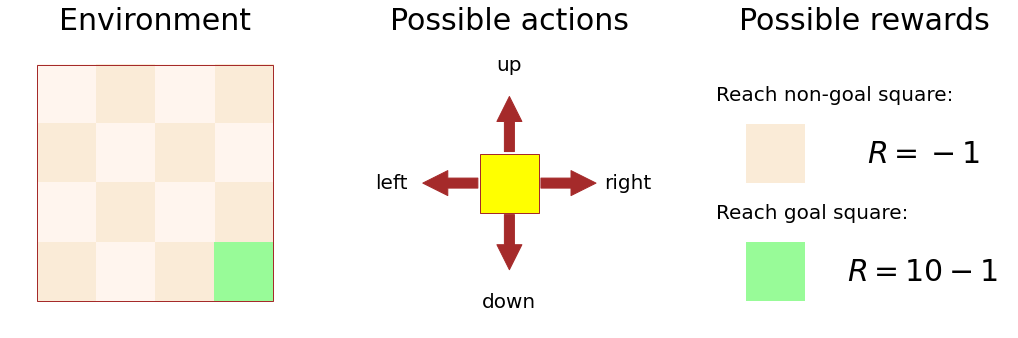

In [ ]:
visualize_environment(env_params)

### Simulating interactions with the gridworld environment

To simulate an agent interacting with our gridworld environment, we need two things: (i) a policy for the agent, and (ii) a function that simulates the state-reward-action loop. 

Below are some simple example policies to evaluate.

In [ ]:
def policy_random(state, env_params, policy_params):
  action_space = env_params["action_space"]
  return np.random.choice(action_space)

def policy_downright(state, env_params, policy_params):
  grid_size = env_params["grid_size"]
  if state%grid_size == grid_size - 1:
    action = "down"
  else:
    action = "right"

  return action

def policy_leftrightdown(state, env_params, policy_params):
  grid_size = env_params["grid_size"]
  num_states = env_params["num_states"]

  if (state%grid_size == (grid_size - 1)) or (state%grid_size == 0):
    action = "down"
  elif (state//grid_size)%2 == 0:
    action = "left"
  elif (state//grid_size)%2 == 1:
    action = "right"
  
  if state == (num_states - grid_size):
    action = "right"

  return action


def policy_right(state, env_params, policy_params):
  return "right"

def policy_up(state, env_params, policy_params):
  return "up"

The below code simulates the state-action-reward loop of an agent interacting with the environment. 

The agent steps through the environment many times, for many episodes. At each time step, it improves its value function and/or policy estimates (we will reuse the below code later when considering the control problem).

In [ ]:
def randomly_initialize_gridworld(env_params):
  terminal_state, state_space = env_params["terminal_state"], env_params["state_space"]

  state = terminal_state
  while state == terminal_state:
    state = np.random.choice(state_space)
  return state


def simulate_gridworld(policy, value, update, env_params, learning_params, policy_params = None, num_episodes = 500):
  state_list, episode_list, delta_list = [], [], []    # Initialize lists of data


  # Simulate for many episodes.
  for i in range(num_episodes):

    state = randomly_initialize_gridworld(env_params)     # Randomly initialize state
    state_list.append(state), episode_list.append(i+1)    # Add initial state info to state and episode lists
    num_steps, done = 0, False                            # Initialize episode progress counters

    # Step forward in time until episode is over.
    while True:
      action = policy(state, env_params, policy_params)                                       # Choose an action according to the policy
      state_new, reward, done = grid_step(state, action, num_steps, env_params)               # Perform the action and see what happens
      move_info = {"state":state, "state_new":state_new, "reward":reward, "action":action}    # Summary of move info

      policy_params, value, delta = update(move_info, policy, value, policy_params, learning_params)     # Use that info to update
      
      
      state_list.append(state_new), episode_list.append(i+1), delta_list.append(delta)   # Record info for plotting      
      num_steps, state = num_steps + 1, state_new                                        # Update state and move on

      if done:
        break

  return policy_params, value, delta_list, state_list, episode_list

### TD algorithm implementation

The following short chunk of code implements the TD algorithm.

In [ ]:
def update_value_TD(move_info, policy, V, policy_params, learning_params):
  alpha, gamma, dt = learning_params["alpha"], learning_params["gamma"], learning_params["dt"]
  state, state_new, reward = move_info["state"], move_info["state_new"], move_info["reward"]


  delta = reward + gamma*V[state_new] - V[state]   # prediction error
  V[state] += alpha*dt*delta                       # TD update

  return policy_params, V, delta

### TD policy evaluation: down-right policy

In [ ]:
# Define learning parameters
alpha, gamma, dt = 0.1, 1, 1
learning_params = {"alpha":alpha, "gamma":gamma, "dt":dt}

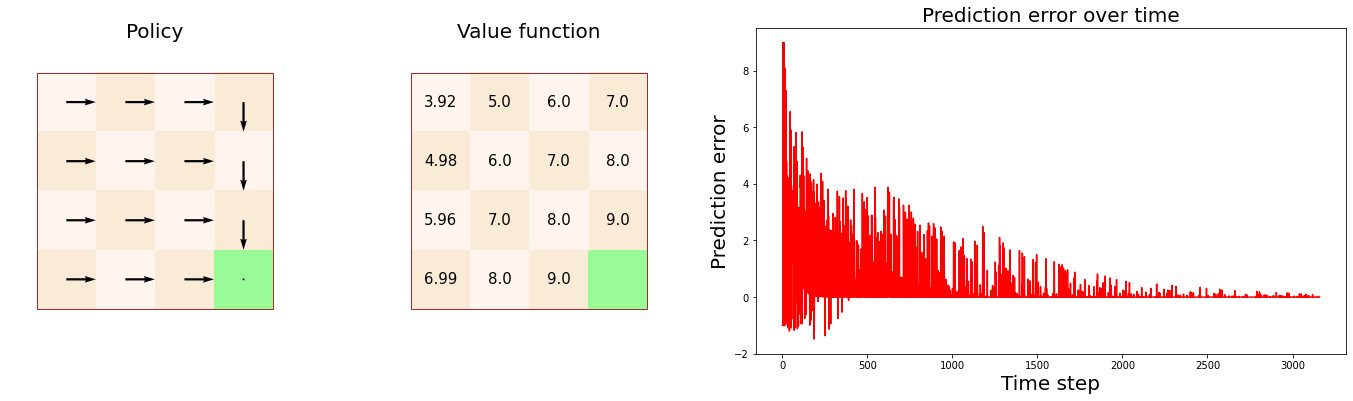

In [ ]:
# Choose policy, then evaluate it
policy = policy_downright 
V, update = np.zeros(env_params["num_states"]), update_value_TD

policy_params, V, delta_list, state_list, episode_list = simulate_gridworld(policy, V, update, env_params, learning_params, num_episodes = 1000)


# Visualize policy and value function estimate
visualize_policy_and_value(policy, V, delta_list, env_params, name='grid_downright')


# Optional (and kind of slow) but informative: show simulation
show_simulation =  True
if show_simulation == True:
  frame_cap = 60
  visualize_simulation(state_list[:frame_cap], episode_list[:frame_cap], env_params)

### TD policy evaluation: random policy

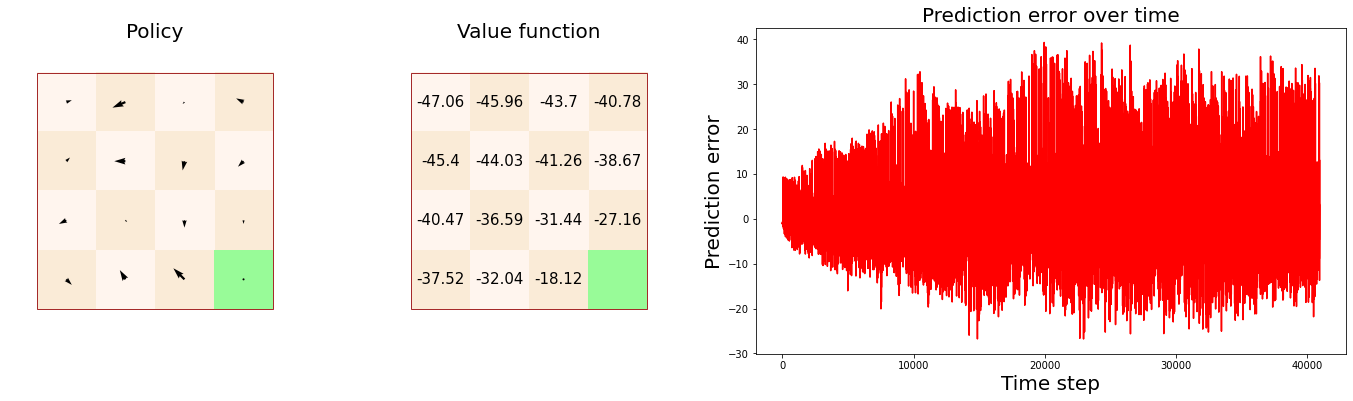

In [ ]:
# Choose policy, then evaluate it
policy = policy_random
V, update = np.zeros(env_params["num_states"]), update_value_TD

policy_params, V, delta_list, state_list, episode_list = simulate_gridworld(policy, V, update, env_params, learning_params, num_episodes = 1000)


# Visualize policy and value function estimate
visualize_policy_and_value(policy, V, delta_list, env_params)


# Optional (and kind of slow) but informative: show simulation
show_simulation =  False
if show_simulation == True:
  frame_cap = 200
  visualize_simulation(state_list[:frame_cap], episode_list[:frame_cap], env_params)

### TD policy evaluation: more complicated example

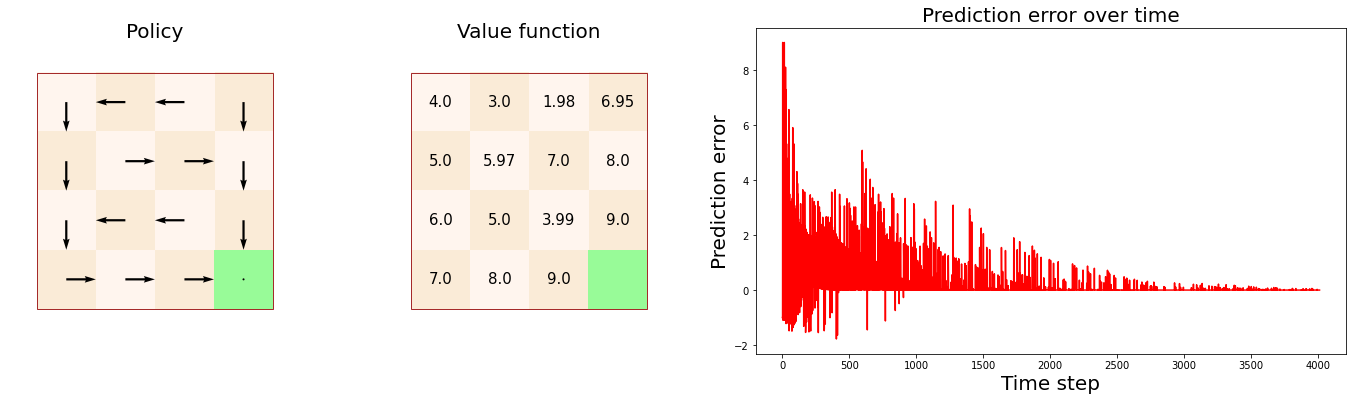

In [ ]:
# Choose policy, then evaluate it
policy = policy_leftrightdown 
V, update = np.zeros(env_params["num_states"]), update_value_TD

policy_params, V, delta_list, state_list, episode_list = simulate_gridworld(policy, V, update, env_params, learning_params, num_episodes = 1000)


# Visualize policy and value function estimate
visualize_policy_and_value(policy, V, delta_list, env_params)


# Optional (and kind of slow) but informative: show simulation
show_simulation =  False
if show_simulation == True:
  frame_cap = 200
  visualize_simulation(state_list[:frame_cap], episode_list[:frame_cap], env_params)

-----------------

## 5. Q-learning and actor-critic: two general model-free control algorithms

The TD learning algorithm works fairly well as a general, model-free approach to solving the prediction problem; what about the control problem?

Two foundational approaches are **Q-learning** and **actor-critic architectures**. Neither approach requires having a model of the environment, and both work by trial-and-error policy improvement. 

Both approaches utilize TD learning as a component (i.e. for policy evaluation), but they differ in how they use prediction error information to perform policy improvement.

### Motivation for the Q-learning algorithm

Suppose we had an estimate $Q(s, a)$ of the optimal action-value function $q_*(s, a)$, i.e.
\begin{equation}
Q(s, a) \approx q_*(s, a) = \max_{\pi} \ \mathbb{E}\left[ G_t | S_t = s, A_t = a \right] \ .
\end{equation}
If $Q(s, a)$ were *equal* to $q_*(s, a)$, by definition, the optimal action would be to pick the action $a$ for which $Q(s, a)$ is largest (with ties broken arbitrarily). This suggests that we can convert knowledge about $Q(s, a)$ into a reasonable policy by picking 'greedy' actions.

But $Q(s, a)$ is generally not equal to the true $q_*(s, a)$, and it may not even be very close, so the greedy policy is generally not optimal. 

The idea behind **Q-learning** is to combine this idea with a **method for exploration**. The agent should sometimes take actions it would not normally take (in the sense of not being greedy with respect to $Q$); if it receives the expected amount of reward, great! If not, update $Q$! 

$Q$ can be updated in response to new information just like $V$ is updated in the TD algorithm (and mathematically, this also ultimately comes from the Bellman equation).

The exploration strategy we consider here is to be **epsilon-greedy**: take a greedy action with respect to the current $Q$ estimate with probability $1 - \epsilon$, and take a random action with probability $\epsilon$. 




### The Q-Learning algorithm

<center>
<figure>
<img src="https://github.com/john-vastola/RL-at-Harvard-tutorial-2022/blob/main/images/QLearningalgo.png?raw=true"  width="800"/>
</figure>
</center>

### Q-learning implementation

In [ ]:
def policy_e_greedy_Q(state, env_params, policy_params):
  action_space = env_params["action_space"]
  Q, epsilon = policy_params["Q"], policy_params["epsilon"]

  coin_flip = np.random.binomial(n=1, p=epsilon)
  if coin_flip == 1:
    action = np.random.choice(action_space)
  else:
    action = action_space[np.argmax(Q[state,:])]

  return action


def update_Q_and_policy_QLearning(move_info, policy, Q, policy_params, learning_params):
  alpha, gamma, dt = learning_params["alpha"], learning_params["gamma"], learning_params["dt"]
  state, state_new, reward = move_info["state"], move_info["state_new"], move_info["reward"]
  action, action_number = move_info["action"], env_params["action_number"]
  action_ = action_number[action]

  max_Q = np.amax(Q[state_new,:])
  delta = reward + gamma*max_Q - Q[state, action_]   # prediction error
  Q[state,action_] += alpha*dt*delta                        # Q-learning update

  policy_params["Q"] = Q             # Update policy

  return policy_params, Q, delta


def convert_Q_to_V(Q):
  V = np.amax(Q, axis=1)
  return V

### Q-learning evaluation

Let's test the tabular Q-learning algorithm above on our gridworld environment, and see if our agent can use it to learn good policies.

In [ ]:
grid_size = 4                    # number of squares along one side of grid; total number of grid squares is (grid_size)**2
terminal_state_number = -1       # number of state corresponding to goal square, from 0 to (grid_size)**2 - 1; -1 corresponds to bottom right
step_limit = 100                 # episode continues until agent either reaches goal square or takes too many steps 

env_params = setup_gridworld(grid_size, terminal_state_number, step_limit)

State space:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Action space:  ['up', 'down', 'right', 'left']


In [ ]:
# Define learning parameters
alpha, gamma, dt = 0.1, 1, 1
learning_params = {"alpha":alpha, "gamma":gamma, "dt":dt}

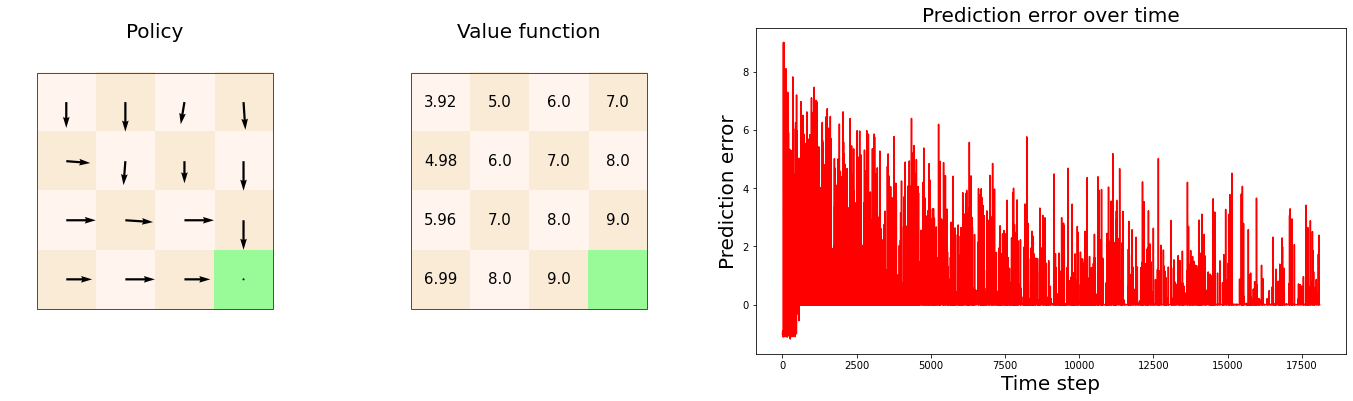

In [ ]:
# Choose policy, then evaluate it
Q, epsilon = np.zeros((env_params["num_states"], env_params["num_actions"])), 0.1
policy_params = {"Q":Q, "epsilon":epsilon}
policy = policy_e_greedy_Q

update = update_Q_and_policy_QLearning
policy_params, Q, delta_list, state_list, episode_list = simulate_gridworld(policy, Q, update, env_params, learning_params, policy_params, num_episodes = 5000)


# Visualize policy and value function estimate
visualize_policy_and_value(policy, convert_Q_to_V(Q), delta_list, env_params, policy_params, name='Q')


# Optional (and kind of slow) but informative: show simulation
show_simulation =  True
if show_simulation == True:
  frame_cap = 500
  visualize_simulation(state_list[:frame_cap], episode_list[:frame_cap], env_params)

### Motivation for the actor-critic algorithm

While Q-learning is certainly useful and important, it is not without problems. One problem is that the Q-value function is closely linked with the agent's policy, creating a conflict between exploration and exploitation: it is optimal to be greedy when $Q$ is accurate, but better to explore different possible actions while learning.

One possibility is to accept that, given a Q-learning strategy with a fixed amount of exploration (e.g. epsilon-greedy with a fixed $\epsilon$), the agent will randomly take bad actions even after learning; alternatively, one must come up with a schedule for reducing exploration with time. This can be done, but it is hard, and often very problem-specific.

**Actor-critic architectures** represent yet another alternative. The basic idea is to represent the policy in a way that is independent of the value function. For example, one can use **action preferences** $h(s, a)$, so that the agent's policy $\pi(a | s)$ can be written as a softmax expression
\begin{equation}
\pi(a | s) = \frac{e^{h(s, a)}}{\sum_b e^{h(s, b)}} \ .
\end{equation}

The action preferences need to be iteratively updated, for example by gradient descent (the value function itself serves as a suitable objective function here). For more information on the technical details, look up the **policy gradient theorem**.

The 'actor-critic' designation comes from the structure of the algorithm. The actor corresponds to the policy $\pi$, which is parameterized by action preferences. The critic corresponds to the value function $V$. One can imagine that the critic computes a prediction error, and then feeds this information to the actor ("Do that more!" or "Do that less!"). The actor then adjusts their performance, the critic offers more feedback, the actor adjusts again, and so on.

### The actor-critic algorithm

<center>
<figure>
<img src="https://github.com/john-vastola/RL-at-Harvard-tutorial-2022/blob/main/images/ACalgo.png?raw=true"  width="800"/>
</figure>
</center>

### Actor-critic implementation

In [ ]:
def policy_pref_tabular_actorcritic(state, env_params, policy_params):
  action_space = env_params["action_space"]
  h = policy_params["h"][state,:]

  p = np.exp(h)/np.sum(np.exp(h))

  action = np.random.choice(action_space, p=p)
  return action


def update_V_and_policy_tabular_actorcritic(move_info, policy, V, policy_params, learning_params):
  alpha, gamma, dt = learning_params["alpha"], learning_params["gamma"], learning_params["dt"]
  state, state_new, reward = move_info["state"], move_info["state_new"], move_info["reward"]
  action, action_number, num_actions = move_info["action"], env_params["action_number"], env_params["num_actions"]
  action_ = action_number[action]

  h = policy_params["h"]


  delta = reward + gamma*V[state_new] - V[state]    # prediction error
  V[state] += alpha*dt*delta                        # TD update

  pi = np.exp(h)/np.sum(np.exp(h))

  for a in range(num_actions):
    if a == action_:
      grad_pi_over_pi = 1 - pi
    else:
      grad_pi_over_pi = - pi
    policy_params["h"][state,a] += alpha*dt*delta*grad_pi_over_pi[state, a]   # Policy gradient update

  return policy_params, V, delta

### Actor-critic evaluation

Let's test the tabular actor-critic algorithm above on our gridworld environment, and see if our agent can use it to learn good policies.

In [ ]:
grid_size = 4                    # number of squares along one side of grid; total number of grid squares is (grid_size)**2
terminal_state_number = -1       # number of state corresponding to goal square, from 0 to (grid_size)**2 - 1; -1 corresponds to bottom right
step_limit = 100                 # episode continues until agent either reaches goal square or takes too many steps 

env_params = setup_gridworld(grid_size, terminal_state_number, step_limit)

State space:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Action space:  ['up', 'down', 'right', 'left']


In [ ]:
# Define learning parameters
alpha, gamma, dt = 0.1, 1, 1
learning_params = {"alpha":alpha, "gamma":gamma, "dt":dt}

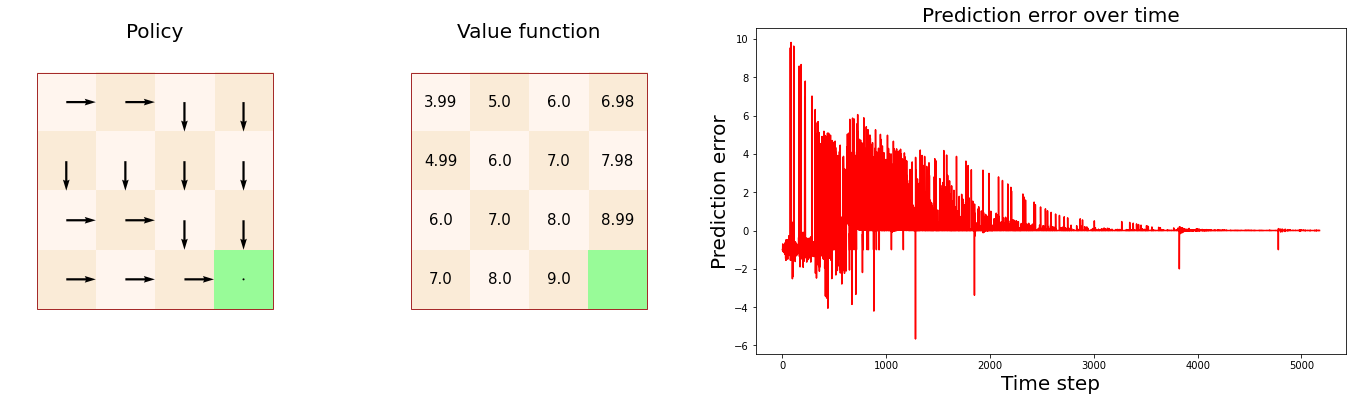

In [ ]:
# Choose policy, then evaluate it
V = np.zeros(env_params["num_states"])
h = np.zeros((env_params["num_states"], env_params["num_actions"]))
policy_params = {"h":h}
policy = policy_pref_tabular_actorcritic

update = update_V_and_policy_tabular_actorcritic
policy_params, V, delta_list, state_list, episode_list = simulate_gridworld(policy, V, update, env_params, learning_params, policy_params, num_episodes = 1500)


# Visualize policy and value function estimate
visualize_policy_and_value(policy, V, delta_list, env_params, policy_params, name='actor_critic')


# Optional (and kind of slow) but informative: show simulation
show_simulation =  True
if show_simulation == True:
  frame_cap = 1000
  visualize_simulation(state_list[:frame_cap], episode_list[:frame_cap], env_params)

-------------------